#### Step 1: Data acquisition + cleanup


In [52]:
import pandas as pd
df = pd.read_csv("TIMES.csv")

In [53]:
# throw away everything except for the m_label field and the pixel values which are scattered across 400 columns labeled rxcy
def prepareDF(dataframe):
    df = dataframe.drop(columns=['font', 'fontVariant', 'strength', 'italic', 'orientation', 'm_top', 'm_left', 'originalH', 'originalW', 'h', 'w'])
    return df

df = prepareDF(df)

In [54]:
import numpy as np

def normalize_X_and_y(dataframe):
    #filters 'm_label' to include only ASCII chars that are common printable characters (from ASCII 34 to 125).
    df1 = dataframe[dataframe['m_label'] > 33]
    df = df1[df1['m_label'] < 126]
    yArray = np.array(df['m_label']) #Extracts the 'm_label' into a NumPy array

    #Feature array
    temp_dataframe = df.drop(columns=['m_label'])
    xArray = np.zeros((len(temp_dataframe), 20, 20))
    for row in range(0, temp_dataframe.shape[0]):
        for i in range(20):
            for j in range(20):
                string = 'r' + str(i) + 'c' + str(j)
                # normalization is done by dividing each pixel value by 255, scaling the pixel values to a range of 0 to 1
                xArray[row, i, j] = temp_dataframe.iloc[row].loc[string] /255
    
    
    return xArray, yArray

xVals, yVals = normalize_X_and_y(df)


In [55]:
def getAsciiDictionaries(yValues):
    unique_vals = set(yValues)
    setSize = len(unique_vals)
    index_to_ascii = {}
    ascii_to_index = {}
    index = 0
    for val in unique_vals:
        ascii_to_index[val] = index
        index_to_ascii[index] = val
        index+=1

    print(index_to_ascii)
    print(ascii_to_index)
    return ascii_to_index, index_to_ascii, setSize

asciiToIndex, indexToAscii, setSize = getAsciiDictionaries(yVals)


{0: np.int64(34), 1: np.int64(35), 2: np.int64(36), 3: np.int64(37), 4: np.int64(38), 5: np.int64(39), 6: np.int64(40), 7: np.int64(41), 8: np.int64(42), 9: np.int64(43), 10: np.int64(44), 11: np.int64(45), 12: np.int64(46), 13: np.int64(47), 14: np.int64(48), 15: np.int64(49), 16: np.int64(50), 17: np.int64(51), 18: np.int64(52), 19: np.int64(53), 20: np.int64(54), 21: np.int64(55), 22: np.int64(56), 23: np.int64(57), 24: np.int64(58), 25: np.int64(59), 26: np.int64(60), 27: np.int64(61), 28: np.int64(62), 29: np.int64(63), 30: np.int64(64), 31: np.int64(65), 32: np.int64(66), 33: np.int64(67), 34: np.int64(68), 35: np.int64(69), 36: np.int64(70), 37: np.int64(71), 38: np.int64(72), 39: np.int64(73), 40: np.int64(74), 41: np.int64(75), 42: np.int64(76), 43: np.int64(77), 44: np.int64(78), 45: np.int64(79), 46: np.int64(80), 47: np.int64(81), 48: np.int64(82), 49: np.int64(83), 50: np.int64(84), 51: np.int64(85), 52: np.int64(86), 53: np.int64(87), 54: np.int64(88), 55: np.int64(89), 5

In [56]:
# Convert yValues array, which originally contains ASCII values, into indices using the ascii_to_index dictionary
def convertToIndex(yValues, ascii_to_index):
    for i in range(len(yValues)):
        yValues[i] = ascii_to_index[yValues[i]]

    return yValues

yVals = convertToIndex(yVals, asciiToIndex)


#### Step 2: Build a Pytorch network


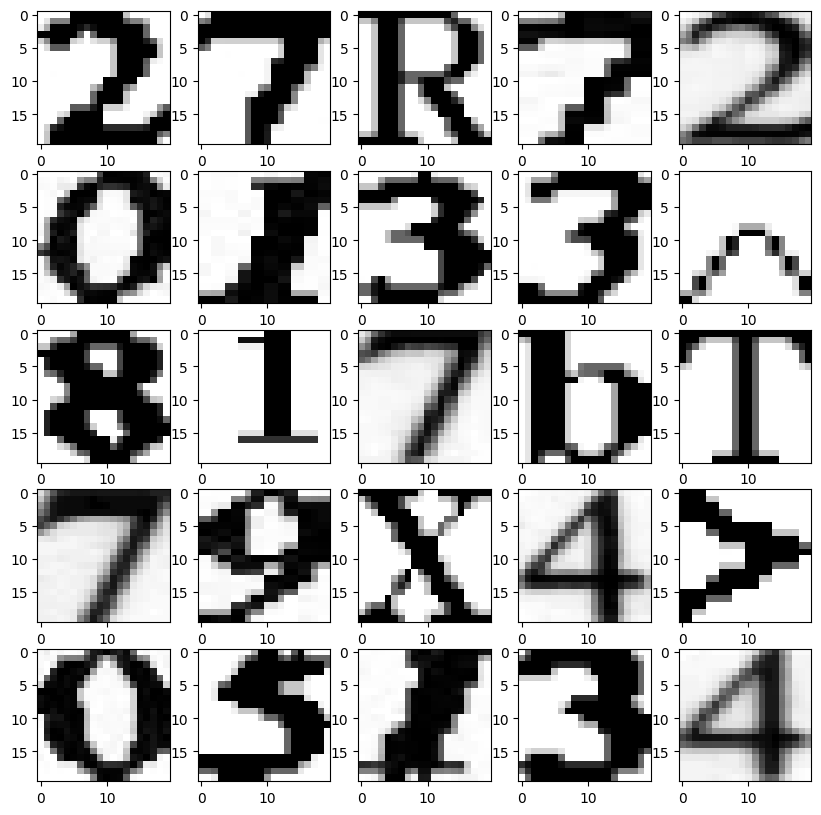

In [57]:
import torchvision
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

plt.figure( figsize= (10, 10) )

for i in np.arange( 25 ):
    plt.subplot( 5, 5, i+1 )
    plt.imshow( xVals[i, :, :], cmap='Greys',interpolation='none' )

plt.show()
Xs = np.reshape(xVals, (-1, 1, 20, 20))

In [58]:
#split the data into train/test
x_tensor = torch.tensor(Xs, dtype=torch.float32)
y_tensor = torch.tensor(yVals)

x_train, x_test, y_train, y_test = train_test_split(x_tensor, y_tensor, random_state=1, test_size=0.9)

training_data = TensorDataset(x_train, y_train)
testing_data = TensorDataset(x_test, y_test)

In [59]:
class Net(nn.Module):
    #sets up the layers and components of the neural network
    def __init__(self):
        super(Net, self).__init__()
        # Set up 1st convolutional layer
        # Uses 6 filters, each w. kernel size of 3x3 pixels. 
        # The input has 1 channel (grayscale image). The output of this layer will be 6 feature maps
        self.conv1 = nn.Conv2d( 1, 6, 3 ) 
                
        self.pool = nn.MaxPool2d( 2, 2 ) # set up max pooling to be a 2x2 block
        
        # Set up 2nd convolutional layer
        # Uses 16 filters, each w. kernel size of 3x3 pixels. 
        # The input has 6 feature maps. The output of this layer will be 16 feature maps        
        self.conv2 = nn.Conv2d( 6, 16, 3 )
        
        # Set up 1st dense layer 
        # 3x3 grid per each of the 16 feature maps from conv2
        self.pooledOutputSize = 16 * 3 * 3 
        self.fc1 = nn.Linear( self.pooledOutputSize, 120 )
        
        #Set up 2nd and 3rd dense layers, which continue to refine the outputs towards the final classification layer
        self.fc2 = nn.Linear( 120, 84 )
        self.fc3 = nn.Linear( 84, setSize ) # predicts one of setSize classes (number of unique characters)

    #-------------------------------#
    # Take an image (or images) and run it through all stages of the net
    # input x is "batch" of images
    def forward( self, x ): 
        # Pass image through 1st convolution layer, activation fn, then max pool
        x = self.pool(F.relu(self.conv1(x))) 
        
        # Pass image through 2nd convolution layer, activation fn, then max pool
        x = self.pool(F.relu(self.conv2(x))) 

        # Prep image 2nd max pooling output to be 1D for dense layer
        x = x.view(-1, self.num_flat_features(x))
        
        # 1D image is passed through 1st dense layer, then relu fn
        x = F.relu(self.fc1(x)) 
        # 2nd dense layer, then relu fn
        x = F.relu(self.fc2(x))
        #3rd dense layer, no activation function on this
        x = self.fc3(x) 
        return x
    
    #Calculate the total number of features in the tensor after the last pooling layer
    # (channels, height, width) multiplies them together to compute the total number of elements 
    # i.e 5X5 feature map * 16 maps = 400 
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()

In [60]:
# model: The neural network model to be trained.
# epochs: The number of complete passes through the entire dataset.
# training_data: The dataset used for training, which includes inputs and corresponding labels.
def train( model, epochs, training_data ): 
    
    # measure the error (loss) during training
    # Correct pred + high confidence = penalized less
    # incorrect pred + high confidence = penalized more
    criterion = nn.CrossEntropyLoss() 

    # use the ADAM optimizer to adjust the weights of the net to minimize the loss
    optimizer = optim.Adam( model.parameters(), lr= 1e-4 ) 
    
    # Load data and gets it in the correct format
    trainloader = torch.utils.data.DataLoader( training_data, batch_size=8,
                                               shuffle=True, num_workers=0 )

    # Iterates through the dataset as many times as specified 
    for epoch in range( epochs ): 

        running_loss = 0.0
        
        # Iterates through the data in batches as provided by trainloader
        for i, data in enumerate( trainloader, 0 ):
            # Extract data
            inputs = x_tensor
            labels = y_tensor
            # zero the previous gradients
            optimizer.zero_grad()

            # computes the predicted outputs using the current state of the model
            outputs = model(inputs) 
            # calculate the loss between the predictions and actual labels
            loss = criterion(outputs, labels) 

            # computes the gradient of the loss with respect to the model parameters (seeing what weights to get better results)
            loss.backward()
            optimizer.step() # update weights 
            
            # log loss for monitoring training progress
            running_loss += loss.item()
            if i % 2000 == 1999:    
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')

In [61]:
print( "Training..." )
train( net, 15, training_data )

Training...
Finished Training


#### Step 3: Exploration and Evaluation


Evaluating...
Accuracy: 54 %


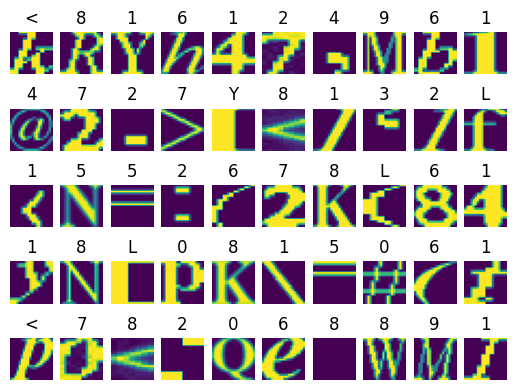

In [62]:
# model: The trained neural network model that needs evaluation.
# testing_data: The dataset used for testing the model.
# iToA (index to ASCII): A dictionary mapping from predicted indices to their corresponding ASCII characters, used for displaying misclassified characters.
def evaluate( model, testing_data, iToA):  
    #load test data
    testloader = torch.utils.data.DataLoader( testing_data, batch_size=1,
                                              shuffle=True, num_workers=0 )
    correct = 0
    total = 0

    with torch.no_grad(): 
        count = 0
        for data in testloader:
            images, labels = data
            outputs = model( images )
            # Extracts the class with the highest predicted score (confidence)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            # If the prediction does not match the label, the misclassified image is visualized
            if predicted != labels:
                ascii = chr(iToA[predicted.item()])
                plt.subplot(5,10, count+1)
                plt.imshow(images[0,0])
                plt.title(ascii)
                plt.axis('off')
                
                count+=1
                if count >=50:
                    break

    # Coarse evaluation
    print( 'Accuracy: %d %%' % ( 100 * correct / total) )

print( "Evaluating..." )
evaluate( net, testing_data, indexToAscii )

**1. Evaluate the network using cross validation (splitting data into training/testing). What is its accuracy?**
54%
